In [1]:
import scipy
import scipy.misc
import numpy as np
import random
import tensorflow as tf
import gym
from tqdm import tqdm
from tqdm import tqdm_notebook
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import lasagne
import theano.tensor as T
import theano

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
class ATARI_wrapper():
    def __init__(self, gamename = "Enduro-v0"):
        self.state_size = (105, 80)
        self.game_title = gamename
        self.actions = ["0", "1", "2", "3", "4", "5", "6", "7", "8"]
        self.n_actions = len(self.actions)
        try:
            self.env = gym.make(self.game_title)
        except:
            print ("ERROR : Can't find " + self.game_title + " environment.")
            return None
        self.env.reset()
    
    def processState(self, state):
        grayimage = np.mean(state, axis = 2)
        downscale = self.downscale2x(grayimage)
        norm = (downscale - 128.0) / 128.0
        return norm
    
    def processAction(self, action):
        return action
    
    def make_reset(self):
        state = self.env.reset()
    
        return self.processState(state)
    
    def make_step(self, action, render = False):
        action = self.processAction(action)
    
        state, ret1, ret2, ret3 = self.env.step(action)
    
        if render:
            self.env.render()
    
        return self.processState(state), ret1, ret2, ret3
    
    def downscale2x(self, image):
        image00 = image[0::2, 0::2]
        image01 = image[0::2, 1::2]
        image10 = image[1::2, 0::2]
        image11 = image[1::2, 1::2]
        return (image00 + image01 + image10 + image11) / 4

In [5]:
class LunarLanding_wrapper():
    def __init__(self):
        self.state_size = (1, 8)
        self.game_title = "LunarLander-v2"
        self.actions = ["DO_NOTHING", "FIRE_LEFT", "FIRE_MAIN", "FIRE_RIGHT"]
        self.n_actions = len(self.actions)
        try:
            self.env = gym.make(self.game_title)
        except:
            print ("ERROR : Can't find " + self.game_title + " environment.")
            return None
        self.env.reset()
    
    def processState(self, state):
        return state.reshape(1, -1)
    
    def processAction(self, action):
        return action
    
    def make_reset(self):
        state = self.env.reset()
    
        return self.processState(state)
    
    def make_step(self, action, render = False):
        action = self.processAction(action)
    
        state, ret1, ret2, ret3 = self.env.step(action)
    
        if render:
            self.env.render()
    
        return self.processState(state), ret1, ret2, ret3

In [6]:
class CartPole_wrapper():
    def __init__(self):
        self.state_size = (1, 4)
        self.game_title = "CartPole-v0"
        self.actions = ["LEFT", "RIGHT"]
        self.n_actions = len(self.actions)
        try:
            self.env = gym.make(self.game_title)
        except:
            print ("ERROR : Can't find " + self.game_title + " environment.")
            return None
        self.env.reset()
    
    def processState(self, state):
        return state.reshape(1, -1)
    
    def processAction(self, action):
        return action
    
    def make_reset(self):
        state = self.env.reset()
    
        return self.processState(state)
    
    def make_step(self, action, render = False):
        action = self.processAction(action)
    
        state, ret1, ret2, ret3 = self.env.step(action)
    
        if render:
            self.env.render()
    
        return self.processState(state), ret1, ret2, ret3

In [7]:
class AVQ_nn():
    def __init__(self, channels_number = 4, image_shape = (1, 8), n_actions = 4, grad_clipping = 10, lr = 0.0001, aelosscoef = 0.1):
        self.input_var = T.tensor4('statebatch')
        self.targetQ = T.fvector('targetQ')
        self.actions = T.ivector('actions')
        self.newstates = T.tensor4("newstatebatch")
        self.actions_onehot = T.extra_ops.to_one_hot(self.actions, n_actions, dtype=np.float32)
        
        self.aelosscoef = aelosscoef
        self.n_actions = n_actions
        self.build_network(channels_number, image_shape)
        self.build_AVQ(grad_clipping, lr)
        self.compile_network()
        
    def build_network(self, channels_number, image_shape):
        self.l1 = lasagne.layers.InputLayer(shape=(None, channels_number, image_shape[0], image_shape[1]), 
                                            input_var = self.input_var)
        self.l2 = lasagne.layers.DenseLayer(self.l1, 60, nonlinearity=lasagne.nonlinearities.leaky_rectify)
        self.l3 = lasagne.layers.DenseLayer(self.l2, 40, nonlinearity=lasagne.nonlinearities.leaky_rectify)
        self.outlayer = lasagne.layers.DenseLayer(self.l3, 20, nonlinearity=lasagne.nonlinearities.leaky_rectify)
        self.encode = lasagne.layers.DenseLayer(self.outlayer, 4, nonlinearity=lasagne.nonlinearities.leaky_rectify)
        self.le3 = lasagne.layers.DenseLayer(self.encode, 20, nonlinearity=lasagne.nonlinearities.leaky_rectify)
        self.le2 = lasagne.layers.DenseLayer(self.le3, 40, nonlinearity=lasagne.nonlinearities.leaky_rectify)
        self.le1 = lasagne.layers.DenseLayer(self.le2, 60, nonlinearity=lasagne.nonlinearities.leaky_rectify)
        self.le0 = lasagne.layers.DenseLayer(self.le1, channels_number * image_shape[0] * image_shape[1])
        self.l_aeout = lasagne.layers.ReshapeLayer(self.le0, shape=(-1, channels_number, image_shape[0], image_shape[1]))
    
        self.actionlayer = lasagne.layers.InputLayer(shape=(None, self.n_actions), input_var = self.actions_onehot)
        self.prins = lasagne.layers.ConcatLayer([self.encode, self.actionlayer], axis = 1)
        self.pr1 = lasagne.layers.DenseLayer(self.prins, 40, nonlinearity=lasagne.nonlinearities.leaky_rectify)
        self.prencode = lasagne.layers.DenseLayer(self.pr1, 4)
    
    def build_AVQ(self, grad_clipping, lr):
        self.l_advantage = lasagne.layers.DenseLayer(self.outlayer, self.n_actions)
        self.l_value = lasagne.layers.DenseLayer(self.outlayer, 1)
        
        self.advantage, self.value, self.ae_out, self.enc, self.prenc = lasagne.layers.get_output([self.l_advantage, self.l_value, self.l_aeout, self.encode, self.prencode])
        self.targetenc = lasagne.layers.get_output(self.encode, inputs = self.newstates)
        
        self.average_advantage = T.mean(self.advantage, keepdims = True, axis = 1)
        
#        self.Qout = self.advantage + self.value - self.average_advantage
        self.Qout = self.advantage
        self.predict = T.argmax(self.Qout, axis = 1)
        
        self.Q = T.sum(self.Qout * self.actions_onehot, axis = 1)
        
        self.ae_error = T.mean(T.sqr(self.ae_out - self.input_var))
        self.td_error = T.mean(T.sqr(self.targetQ - self.Q))
        
        self.loss = self.ae_error * self.aelosscoef + self.td_error
        params = self.get_all_params()
        self.all_grads = T.grad(self.loss, params)
        self.scaled_grads = lasagne.updates.total_norm_constraint(self.all_grads, grad_clipping)
        self.updates = lasagne.updates.adam(self.scaled_grads, params, learning_rate=lr)
        
        self.pr_loss_batch = T.mean(T.sqr(self.targetenc - self.prenc), axis = 1)
        self.pr_loss = T.mean(self.pr_loss_batch)
        pr_params = [self.pr1.W, self.pr1.b, self.prencode.W, self.prencode.b]
        self.pr_grads = T.grad(self.pr_loss, pr_params)
        self.pr_scaled_grads = lasagne.updates.total_norm_constraint(self.pr_grads, grad_clipping)
        self.pr_updates = lasagne.updates.adam(self.pr_scaled_grads, pr_params, learning_rate=lr)
        
        enc_layers = [self.l2, self.l3, self.outlayer, self.encode, self.le3, self.le2, self.le1, self.le0]
        enc_params = [l.W for l in enc_layers] + [l.b for l in enc_layers]
        self.enc_grads = T.grad(self.ae_error, enc_params)
        self.enc_scaled_grads = lasagne.updates.total_norm_constraint(self.enc_grads, grad_clipping)
        self.enc_updates = lasagne.updates.adam(self.enc_scaled_grads, enc_params, learning_rate=lr)
        
    def compile_network(self):
        self.Qout_fn = theano.function([self.input_var], self.Qout)
        self.actionpred_fn = theano.function([self.input_var], self.predict)
        self.train_fn = theano.function([self.input_var, self.targetQ, self.actions], [self.ae_error, self.td_error], updates = self.updates)
        self.train_predfn = theano.function([self.input_var, self.actions, self.newstates], self.pr_loss_batch, updates = self.pr_updates)
        self.train_encoder = theano.function([self.input_var], self.ae_error, updates = self.enc_updates)
        
    def get_all_params(self):
#        return lasagne.layers.get_all_params([self.l_advantage, self.l_value], trainable = True)
        return lasagne.layers.get_all_params(self.l_advantage, trainable = True)
    
    def get_all_params_values(self):
#        return lasagne.layers.get_all_param_values([self.l_advantage, self.l_value], trainable = True)
        return lasagne.layers.get_all_param_values(self.l_advantage, trainable = True)
    
    def set_all_params_values(self, values):
#        return lasagne.layers.set_all_param_values([self.l_advantage, self.l_value], values, trainable = True)
        return lasagne.layers.set_all_param_values(self.l_advantage, values, trainable = True)

In [8]:
class experience_buffer():
    def __init__(self, buffer_size = 10000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self, experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self, size):
        size = min(size, len(self.buffer))
        return np.reshape(np.array(random.sample(self.buffer, size)),[size,5])

In [9]:
class window_aggregator():
    def __init__(self, window_length, state_shape):
        self.state_shape = state_shape
        self.window_length = window_length
        
        assert len(self.state_shape) == 2
        assert self.window_length >= 1
        
        self.start_aggregator_shape = (window_length, state_shape[0], state_shape[1])
                                             
        self.aggregator = np.zeros(self.start_aggregator_shape)
        
    def reset(self):
        self.aggregator = np.zeros(self.start_aggregator_shape)
                                       
    def add_state(self, state):
        state = np.expand_dims(state, 0)
        self.aggregator = np.append(self.aggregator, state, axis = 0)
    
    def get_window(self):
        return self.aggregator[-self.window_length:,:,:]                                                                           

In [10]:
class egreedy_agent():
    def __init__(self, n_actions, actionpred_fn, startE = 1, endE = 0.1, anneling_steps = 50000):
        self.startE = startE
        self.endE = endE
        self.anneling_steps = anneling_steps
        self.stepE = (self.startE - self.endE) / self.anneling_steps
        self.n_actions = n_actions
        self.actionpred_fn = actionpred_fn
    
    def choose_action(self, state, current_step):
        if current_step > self.anneling_steps:
            epsilon = self.endE
        else:
            epsilon = self.startE - self.stepE * current_step
        
        if np.random.rand(1) < epsilon:
            a = np.random.randint(0, self.n_actions)
        else:
            a = self.actionpred_fn(np.expand_dims(state, axis = 0))[0]
            
        return a

In [11]:
class boltzman_agent:
    def __init__(self, n_actions, Qout_fn, startT = 1000, endT = 0.1, anneling_steps = 50000):
        self.startT = startT
        self.endT = endT
        self.anneling_steps = anneling_steps
        self.logstep = (np.log(startT) - np.log(endT)) / anneling_steps
        self.n_actions = n_actions
        self.Qout_fn = Qout_fn
    
    def choose_action(self, state, current_step):
        scores = self.Qout_fn(np.expand_dims(state, axis = 0))[0]
        if current_step > self.anneling_steps:
            exponents = np.exp((scores - np.max(scores)) / self.endT)
        else:
            current_temp = self.startT / np.exp(self.logstep * current_step)
            exponents = np.exp((scores - np.max(scores)) / current_temp)
        probs = exponents / np.sum(exponents)
        return np.random.choice(self.n_actions, p = probs)

In [34]:
class DDQL():
    def __init__(self, lparams, env, agent = {"agent":"egreedy", "params":{}}):
        self.grad_clip = lparams["grad_clipping"]
        self.lr = lparams["learning_rate"]
        self.window_size = lparams["window_size"]
        self.batch_size = lparams["batch_size"]
        self.gamma = lparams["gamma"]
        self.MQN_updatefreq = lparams["MQN_updatefreq"]
        self.TQN_updatefreq = lparams["TQN_updatefreq"]
        self.TQN_updaterate = lparams["TQN_updaterate"]
        self.print_freq = lparams["print_freq"]
        self.pretrain_steps = lparams["pretrain_steps"]
        self.buffer_size = lparams["buffer_size"]
        self.pretrain_over = False
        self.maxprerror = None
        
        self.env = env
        self.mainQN = AVQ_nn(self.window_size, self.env.state_size, self.env.n_actions, self.grad_clip, self.lr)
        self.targetQN = AVQ_nn(self.window_size, self.env.state_size, self.env.n_actions, self.grad_clip, self.lr)

        self.lList = []
        self.rList = []
        self.aeList = []
        self.total_steps = 0
        
        self.window = window_aggregator(self.window_size, self.env.state_size)
        self.experience_storage = experience_buffer(self.buffer_size)
        self.agent = self.getAgent(agent["agent"], agent["params"])
            
    def getAgent(self, agent, agentparams):
        if agent == "egreedy":
            agent = egreedy_agent(self.env.n_actions, self.mainQN.actionpred_fn, **agentparams)
        elif agent == "boltzman":
            agent = boltzman_agent(self.env.n_actions, self.mainQN.Qout_fn, **agentparams)
        else:
            raise ValueError("Unknown agent")
            
        return agent
            
    def updateTarget(self, completeupdate = False):
        if completeupdate:
            self.targetQN.set_all_params_values(self.mainQN.get_all_params_values())
        else:
            targetparams = self.targetQN.get_all_params_values()
            mainparams = self.mainQN.get_all_params_values()
            ur = self.TQN_updaterate
        
            assert len(targetparams) == len(mainparams)
            for k in range(0, len(targetparams)):
                targetparams[k] = targetparams[k] * (1.0 - ur) + mainparams[k] * ur
        
            self.targetQN.set_all_params_values(targetparams)
            
    def train(self, num_episodes, frame_limit, render = True):
        self.updateTarget(True)
        self.window.reset()
        
        for episode_num in tqdm_notebook(range(num_episodes), desc = "RL train"):
            state = self.env.make_reset()
            self.window.add_state(state)
            window_state = self.window.get_window()
            episode_rewards = np.zeros(frame_limit)
            episode_aeerrors = np.array([])
            
            for iteration in xrange(0, frame_limit):
                action = self.agent.choose_action(window_state, self.total_steps)
                new_state, reward, gameover, _ = self.env.make_step(action, render)
                self.window.add_state(new_state)
                new_window_state = self.window.get_window()
                experience = np.reshape(np.array([window_state, action, reward, new_window_state, gameover]),[1,5])
                self.experience_storage.add(experience)
                episode_rewards[iteration] = reward
                
                if self.pretrain_over:
                    self.total_steps += 1
                
                    if self.total_steps % (self.TQN_updatefreq) == 0:
                        self.updateTarget()
                
                    if self.total_steps % (self.MQN_updatefreq) == 0:
                        train_batch = self.experience_storage.sample(self.batch_size)
                        old_state_batch = np.stack(train_batch[:,0])
                        new_state_batch = np.stack(train_batch[:,3])
                        action_vector = (train_batch[:,1]).astype(np.int32)
                        end_multiplier = -(train_batch[:,4] - 1)
                        rewards_vector = train_batch[:,2]
                        errors_vector = self.mainQN.train_predfn(old_state_batch, action_vector, new_state_batch)
                        if self.maxprerror == None:
                            self.maxprerror = np.max(errors_vector)
                        else:
                            self.maxprerror = max(self.maxprerror, np.max(errors_vector))
                        rewards_vector = rewards_vector + errors_vector * 50.0 / (self.maxprerror * self.total_steps)
                        Q1 = self.mainQN.actionpred_fn(new_state_batch)
                        Q2 = self.targetQN.Qout_fn(new_state_batch)
                        
                        doubleQ = Q2[range(self.batch_size),Q1]
                        targetQ = (rewards_vector + (self.gamma * doubleQ * end_multiplier)).astype(np.float32)
                        
                        aeerror, tderror = self.mainQN.train_fn(old_state_batch, targetQ, action_vector)
                        episode_aeerrors = np.append(episode_aeerrors, aeerror)
                else:
                    train_batch = self.experience_storage.sample(self.batch_size)
                    old_state_batch = np.stack(train_batch[:,0])
                    new_state_batch = np.stack(train_batch[:,3])
                    action_vector = (train_batch[:,1]).astype(np.int32)
                    aeerror1 = self.mainQN.train_encoder(old_state_batch)
                    aeerror2 = self.mainQN.train_encoder(new_state_batch)
                    episode_aeerrors = np.append(episode_aeerrors, (aeerror1 + aeerror2)/2)
                    errors_vector = self.mainQN.train_predfn(old_state_batch, action_vector, new_state_batch)
                    
                    if self.maxprerror == None:
                        self.maxprerror = np.max(errors_vector)
                    else:
                        self.maxprerror = max(self.maxprerror, np.max(errors_vector))
                    
                    self.pretrain_steps -= 1;
                    if self.pretrain_steps <= 0:
                        self.pretrain_over = True
                        
                state = new_state
                window_state = new_window_state
            
                if gameover:
                    self.window.reset()
                    break
    
            total_reward = np.sum(episode_rewards)
            total_aeerror = np.mean(episode_aeerrors)
            self.lList.append(iteration)
            self.rList.append(total_reward)
            self.aeList.append(total_aeerror)
            if len(self.rList) % self.print_freq == 0:
                tqdm.write(" ".join(["========= Episode", str(episode_num), "================================================"]))
                tqdm.write(" ".join(["Total steps:", str(self.total_steps)]))
                tqdm.write(" ".join(["Episode rewards, last 10:", str(self.rList[-10:])]))
                tqdm.write(" ".join(["Mean over last", str(self.print_freq), "episodes:", str(np.mean(self.rList[-self.print_freq:]))]))
                tqdm.write(" ".join(["Episode lengths, last 10:", str(self.lList[-10:])]))
                tqdm.write(" ".join(["AEerror, mean over last 10:", str(np.mean(self.aeList[-10:]))]))
                tqdm.write("===================================================================" + "=" * len(str(episode_num)))

In [35]:
def plot_rewards(ddqlmodel, meanwindow = 250):
    rlist = [ddqlmodel.rList[0]] * meanwindow + ddqlmodel.rList
    x = np.cumsum(ddqlmodel.lList)
    y = [np.mean(rlist[k:k+meanwindow]) for k in range(len(rlist) - meanwindow)]
    plt.plot(x, y)

In [36]:
#llenv = LunarLanding_wrapper()
cpenv = CartPole_wrapper()

[2017-05-01 05:04:22,857] Making new env: CartPole-v0


In [37]:
lparams = {"grad_clipping" : 50,
           "learning_rate" : 0.005,
           "window_size" : 1,
           "batch_size" : 8,
           "buffer_size" : 128,
           "gamma" : 0.98,
           "MQN_updatefreq" : 1,
           "TQN_updatefreq" : 4,
           "TQN_updaterate" : 0.2,
           "print_freq" : 500,
           "pretrain_steps" : 5000,
           "render" : False}

In [38]:
egreedyagentinfo = {"agent" : "egreedy",
                    "params" : {"startE": 0.5,
                                "endE" : 0.1,
                                "anneling_steps":1000}}

In [39]:
boltzmanagentinfo = {"agent" : "boltzman",
                     "params" : {"startT": 10,
                                 "endT" : 1,
                                 "anneling_steps":10000}}

In [40]:
ddql = DDQL(lparams, cpenv, egreedyagentinfo)

In [41]:
ddql.train(num_episodes = 15000, frame_limit = 500, render = False)

========= Episode 499 ================================================
Total steps: 36841
Episode rewards, last 10: [500.0, 186.0, 84.0, 31.0, 500.0, 500.0, 500.0, 500.0, 500.0, 109.0]
Mean over last 500 episodes: 83.682
Episode lengths, last 10: [499, 185, 83, 30, 499, 499, 499, 499, 499, 108]
AEerror, mean over last 10: 0.173185683523
========= Episode 999 ================================================
Total steps: 133380
Episode rewards, last 10: [30.0, 28.0, 154.0, 143.0, 72.0, 117.0, 35.0, 108.0, 15.0, 60.0]
Mean over last 500 episodes: 193.078
Episode lengths, last 10: [29, 27, 153, 142, 71, 116, 34, 107, 14, 59]
AEerror, mean over last 10: 0.514058912617
========= Episode 1499 ================================================
Total steps: 237148
Episode rewards, last 10: [500.0, 500.0, 500.0, 500.0, 500.0, 16.0, 11.0, 119.0, 58.0, 16.0]
Mean over last 500 episodes: 207.536
Episode lengths, last 10: [499, 499, 499, 499, 499, 15, 10, 118, 57, 15]
AEerror, mean over last 10: 0.267

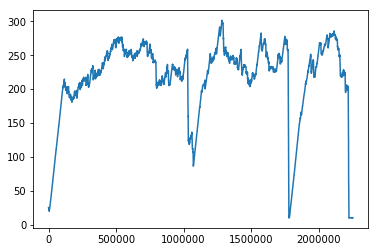

In [49]:
plot_rewards(ddql, 500)

График наград у стратегии исследования с поощрением исследования. Так как эта стратегия влияет на работу агента модифицируя награды у наборов (s_t, a_t, r_t, s_t+1), то с этим алгоритмом применимы предыдущие стратегии исследования(е-жадная и больцман). 